# Poem: Logistic Regression

For this project, the text is the feature and the label is the date of the poem.

We use logistic regression for a multi-class text classification task.

With no preprocessing, the model has 304 targets. We will present the results of different models depending on the preprocessing.

In [1]:
# If you do not have stopwords
import nltk
nltk.download("stopwords")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f60b6c662a0>>
Traceback (most recent call last):
  File "/home/tofeha/miniconda3/envs/NLP1/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
[nltk_data] Downloading package stopwords to /home/tofeha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 🎓 Library

In [ ]:
# Misc
import os
import numpy as np
import pandas as pd
import pickle
import re

# Training
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


# Plotting
import matplotlib.pyplot as plt 

# Environment variables
import sys
sys.path.append("../")
from utils import DATA, BENCHMARK_TABLE

RANDOM_STATE = 42

if not os.path.exists(DATA):
    raise FileNotFoundError(f"Data directory {DATA} does not exist. Please create it and add the data files.")

In [2]:
poems_df = pd.read_parquet(DATA + "de_poems.parquet")

In [3]:
poems_df.head(3)["text"].values

array(['Gebohrn, und wiederumb, o Mensch, gebohren werden,\nErrettet dich vom Tod und hilfft dir in Beschwerden.',
       'Es suchte niemand Gott, liegt er gleich unterm Leben,\nWär er nicht Lieb und hätt es nicht mit Lieb umbgeben.',
       'Die ist in Gott, und Gott der ist zugleich in Ihr,\nIn der ich leb, und die auch wieder lebt in mir.'],
      dtype=object)

# Preprocessing

In [ ]:
from utils import get_period

poems = poems_df.copy()

# Transform all date to centuries, else we have 304 classes
poems["creation"] = poems["creation"].astype(int)

# For model A
poems["century"] = poems["creation"].apply(lambda x: str(x // 100 + 1))

# For model B
poems["movement"] = poems["creation"].apply(get_period)

def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    return ' '.join(tokens)

poems["cleaned_text"] = poems["text"].apply(preprocess)

In [5]:
poems.head(3)

,title,text,author,creation,century,movement,cleaned_text
0,94.Wieder Geburt,"Gebohrn, und wiederumb, o Mensch, gebohren wer...","Czepko von Reigersfeld, Daniel",1632,17,Baroque,gebohrn und wiederumb o mensch gebohren werden...
1,56.Liebe ist der Grund der Welt,"Es suchte niemand Gott, liegt er gleich unterm...","Czepko von Reigersfeld, Daniel",1632,17,Baroque,es suchte niemand gott liegt er gleich unterm ...
2,7.Gott ergebene Seele,"Die ist in Gott, und Gott der ist zugleich in ...","Czepko von Reigersfeld, Daniel",1632,17,Baroque,die ist in gott und gott der ist zugleich in i...


## Model creation and tuning

When calling the `fit` method of the model, the y parameter will be different (either century or movement).

We use SMOTE in order to create synthetic samples for the minority class (11th century).

This reduces accuracy, but increases F1 score.

In [6]:
# Remove german stop words
german_stop_words = stopwords.words("german")

# Pipeline to fine-tune encoding and model
# No need to fit_transform, pipeline will do it
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words=german_stop_words, ngram_range=(1, 2), max_df = 0.9, max_features=350000)),
    # To keep the interesting features
    ("SMOTE", SMOTE(random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(random_state = RANDOM_STATE, solver = "sag", penalty = "l2", max_iter = 100, verbose = 10, class_weight="balanced"))
])

x = poems["cleaned_text"]
# y will be defined depending on the model

In [7]:
# For overall better config: penalty = "L2", solver = "lbfgs", max_iter = 100, max_features = 350000, ngram_range(1, 2)
# For better accuracy on 19th, same thing with "sag"

# https://stackoverflow.com/questions/44066264/how-to-choose-parameters-in-tfidfvectorizer-in-sklearn-during-unsupervised-clust

# Hyperparameter grid
param_grid = [
    {
    #    "tfidf__max_df": [0.9, 1.0],
    #    "tfidf__ngram_range": [(1, 1), (1, 2), (1, 3)],
    #    "tfidf__max_features": [200000, 250000, 300000, 350000],
    #    "clf__class_weight": [None, "balanced"],
    #    "clf__class_weight": ["balanced", None],
    #    "clf__solver": ["lbfgs", "sag"],
    #    "clf__penalty": ["l1", "l2"],
    #    "clf__max_iter": [100, 350]
    }
]

clf = GridSearchCV(pipeline, param_grid, n_jobs = 2, cv = 3, verbose = True)


# Model A: SMOTE, Per Century

Each poem is mapped to a century.

Our feature is `text`, and the label is `century`.

## Step 1: Feature selection

In [8]:
y = poems["century"]

In [9]:
print(f"Currently have {len(poems)} poems with {len(y.unique())} dates.")

Currently have 71570 poems with 8 dates.


## Step 2: Data splitting and model training

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [11]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((57256,), (14314,), (57256,), (14314,))

### Data Augment

Execute only if you want to try the augmentation.


In [12]:
from utils import data_augment

shuffled_texts, shuffled_labels = data_augment(x_train, y_train)
x_train = pd.concat([x_train, pd.Series(shuffled_texts)], ignore_index=True)
y_train = pd.concat([y_train, pd.Series(shuffled_labels)], ignore_index=True)

### Training

In [13]:
clf.fit(x_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1, change: 1
Epoch 1, change: 1
Epoch 2, change: 0.12072668
Epoch 2, change: 0.12641973
Epoch 3, change: 0.053824527
Epoch 3, change: 0.067800298
Epoch 4, change: 0.037929837
Epoch 4, change: 0.035666061
Epoch 5, change: 0.025468954
Epoch 5, change: 0.024469786
Epoch 6, change: 0.01758575
Epoch 6, change: 0.017922754
Epoch 7, change: 0.035502525
Epoch 7, change: 0.013272598
Epoch 8, change: 0.01698169
Epoch 8, change: 0.027527538
Epoch 9, change: 0.016752268
Epoch 9, change: 0.0076253178
Epoch 10, change: 0.0084388981
Epoch 10, change: 0.0064002471
Epoch 11, change: 0.016106921
Epoch 12, change: 0.011262015
Epoch 11, change: 0.0053085456
Epoch 13, change: 0.0076037825
Epoch 12, change: 0.018228603
Epoch 14, change: 0.0031362965
Epoch 13, change: 0.0036922822
Epoch 15, change: 0.0014195906
Epoch 14, change: 0.0012221578
Epoch 16, change: 0.00078611862
Epoch 15, change: 0.0019835989
Epoch 17, change: 0.00019974276
Epoch 16,

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.6min


Epoch 22, change: 0.00013559406
convergence after 23 epochs took 99 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.7min


Epoch 1, change: 1
Epoch 2, change: 0.12238573
Epoch 3, change: 0.071927836
Epoch 4, change: 0.037356662
Epoch 5, change: 0.023847392
Epoch 6, change: 0.032702189
Epoch 7, change: 0.014097594
Epoch 8, change: 0.014645838
Epoch 9, change: 0.015955733
Epoch 10, change: 0.0078966992
Epoch 11, change: 0.0048691612
Epoch 12, change: 0.014609438
Epoch 13, change: 0.0040888494
Epoch 14, change: 0.0011048893
Epoch 15, change: 0.00071970121
Epoch 16, change: 0.0009643633
Epoch 17, change: 0.00040577012
Epoch 18, change: 0.00033205839
Epoch 19, change: 0.00040967601
Epoch 20, change: 0.00035783615
convergence after 21 epochs took 78 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.3min


Epoch 1, change: 1
Epoch 2, change: 0.1127852
Epoch 3, change: 0.056630317
Epoch 4, change: 0.040069942
Epoch 5, change: 0.04859648
Epoch 6, change: 0.02119245
Epoch 7, change: 0.015680858
Epoch 8, change: 0.016116475
Epoch 9, change: 0.011409291
Epoch 10, change: 0.0086811444
Epoch 11, change: 0.0037501129
Epoch 12, change: 0.0015462189
Epoch 13, change: 0.0039294851
Epoch 14, change: 0.001097583
Epoch 15, change: 0.00076914842
Epoch 16, change: 0.0006125964
Epoch 17, change: 0.00033304457
Epoch 18, change: 0.00011009111
Epoch 19, change: 0.00010186383
convergence after 20 epochs took 95 seconds


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.6min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9,
                                                        max_features=350000,
                                                        ngram_range=(1, 2),
                                                        stop_words=['aber',
                                                                    'alle',
                                                                    'allem',
                                                                    'allen',
                                                                    'aller',
                                                                    'alles',
                                                                    'als',
                                                                    'also',
                                                                    'am', 'an',
                                                                    'ander',
                                                                    'andere',
                                                                    'anderem',
                                                                    'anderen',
                                                                    'anderer',
                                                                    'anderes',
                                                                    'anderm',
                                                                    'andern',
                                                                    'anderr',
                                                                    'anders',
                                                                    'auch',
                                                                    'auf',
                                                                    'aus',
                                                                    'bei',
                                                                    'bin',
                                                                    'bis',
                                                                    'bist',
                                                                    'da',
                                                                    'damit',
                                                                    'dann', ...])),
                                       ('SMOTE', SMOTE(random_state=42)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42,
                                                           solver='sag',
                                                           verbose=10))]),
             n_jobs=2, param_grid=[{}], verbose=True)

In [14]:
century_model = clf.best_estimator_
century_model

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=350000,
                                 ngram_range=(1, 2),
                                 stop_words=['aber', 'alle', 'allem', 'allen',
                                             'aller', 'alles', 'als', 'also',
                                             'am', 'an', 'ander', 'andere',
                                             'anderem', 'anderen', 'anderer',
                                             'anderes', 'anderm', 'andern',
                                             'anderr', 'anders', 'auch', 'auf',
                                             'aus', 'bei', 'bin', 'bis', 'bist',
                                             'da', 'damit', 'dann', ...])),
                ('SMOTE', SMOTE(random_state=42)),
                ('clf',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='sag', verbose=10))])

In [15]:
century_model.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(max_df=0.9, max_features=350000, ngram_range=(1, 2),
                   stop_words=['aber', 'alle', 'allem', 'allen', 'aller', 'alles',
                               'als', 'also', 'am', 'an', 'ander', 'andere',
                               'anderem', 'anderen', 'anderer', 'anderes',
                               'anderm', 'andern', 'anderr', 'anders', 'auch',
                               'auf', 'aus', 'bei', 'bin', 'bis', 'bist', 'da',
                               'damit', 'dann', ...])),
  ('SMOTE', SMOTE(random_state=42)),
  ('clf',
   LogisticRegression(class_weight='balanced', random_state=42, solver='sag',
                      verbose=10))],
 'transform_input': None,
 'verbose': False,
 'tfidf': TfidfVectorizer(max_df=0.9, max_features=350000, ngram_range=(1, 2),
                 stop_words=['aber', 'alle', 'allem', 'allen', 'aller', 'alles',
                             'als', 'also', 'am', 'an', 'ander', 'andere'

#### Quick save

In [ ]:
pickle.dump(century_model, open("../trained/LR_Century_model_SMOTE_SAG.pkl", "wb"))

## Step 3: Evaluation

#### Quick load

In [ ]:
century_model = pickle.load(open("../trained/LR_Century_model_SMOTE_lbfgs.pkl", "rb"))

### Prediction

In [16]:
y_pred = century_model.predict(x_test)

### Metrics

In [17]:
print(classification_report(y_test,y_pred, zero_division=0))

results = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

recall_avg = results["weighted avg"]["recall"]
f1_score_avg = results["weighted avg"]["f1-score"]
precision_avg = results["weighted avg"]["precision"]

              precision    recall  f1-score   support

          11       0.56      0.42      0.48        55
          13       0.88      0.39      0.54        18
          14       0.80      0.78      0.79       189
          16       0.95      0.83      0.89       210
          17       0.92      0.92      0.92      4032
          18       0.77      0.75      0.76      2880
          19       0.86      0.88      0.87      6476
          20       0.59      0.57      0.58       454

    accuracy                           0.85     14314
   macro avg       0.79      0.69      0.73     14314
weighted avg       0.85      0.85      0.85     14314



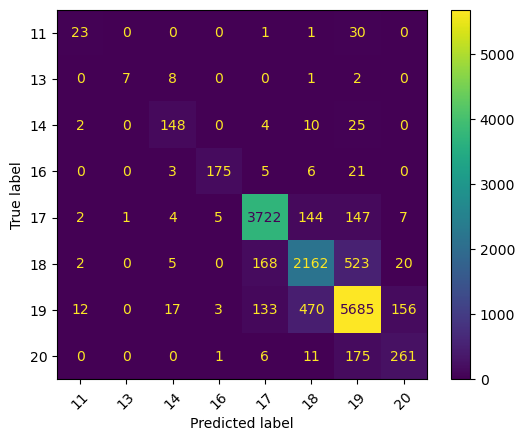

In [18]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

heat = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=century_model.classes_)
fig, ax = plt.subplots()  # optional: adjust figure size
heat.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

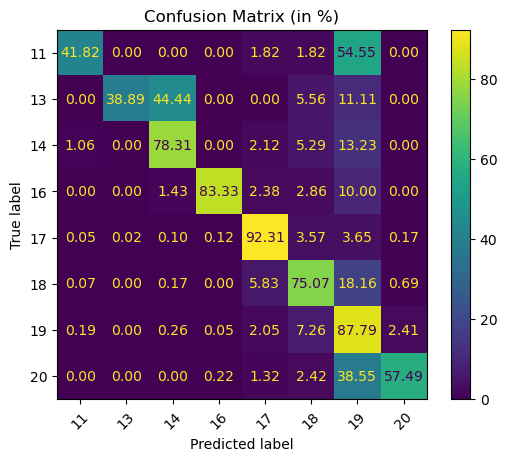

In [19]:
# Normalize it (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=century_model.classes_)
disp.plot(values_format='.2f')  # values_format to control decimal places
plt.title('Confusion Matrix (in %)')
plt.xticks(rotation=45)
plt.show()


In [20]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


In [21]:
# Use predict_proba to get probabilities for each class
y_pred_proba = century_model.predict_proba(x_test)

# Compute ROC AUC score
avg_roc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(f"ROC AUC: {avg_roc:.2f}")

ROC AUC: 0.98


### Saving for benchmark

In [22]:
benchmark = pd.read_parquet(BENCHMARK_TABLE)
benchmark.loc[("TF-IDF", "Logistic Regression"), ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC"]] = [
    recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc
]


In [23]:
# Save the benchmark table
benchmark.to_parquet(BENCHMARK_TABLE, index=True)

# Model B: SMOTE, Per Movement

Each poem is mapped to a German literary movement.

Our feature is `text`, and the label is `movement`.

## Step 1: Feature selection

In [ ]:
y = poems["movement"]

In [ ]:
print(f"Currently have {len(poems)} poems with {len(y.unique())} movements.")

## Step 2: Data splitting and model training

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
movement_model = clf.best_estimator_
movement_model

In [ ]:
movement_model.get_params()

#### Quick save

In [ ]:
pickle.dump(movement_model, open("../trained/LR_Movement_model.pkl", "wb"))

## Step 3: Evaluation and finetuning

#### Quick load

In [ ]:
# Load just in case
model = pickle.load(open("../trained/LR_Movement_model.pkl", "rb"))

In [ ]:
y_pred = movement_model.predict(x_test)

In [ ]:
print(classification_report(y_test,y_pred, zero_division=0))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

heat = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_model.classes_)
fig, ax = plt.subplots()  # optional: adjust figure size
heat.plot(ax=ax)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Normalize it (row-wise percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=movement_model.classes_)
disp.plot(values_format='.2f')  # values_format to control decimal places
plt.title('Confusion Matrix (in %)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")